In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erfc, erfcinv

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


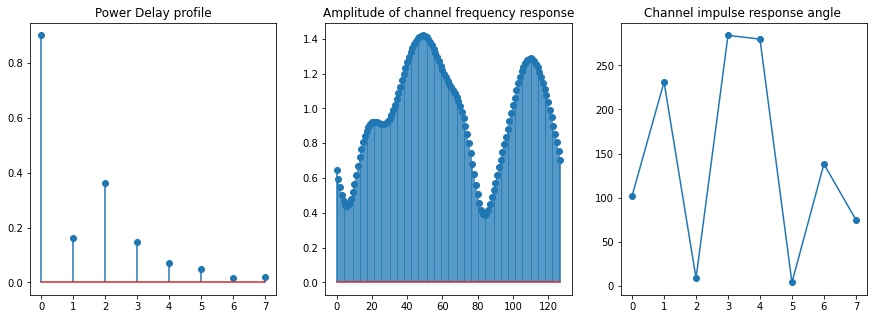

In [2]:
ser = 10**(-5) #Symbol error rate we want to achieve




mat = scipy.io.loadmat('CIR.mat')
mat['h'].shape
CIR = mat['h']
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.stem(np.abs(CIR))

plt.title("Power Delay profile")

plt.subplot(133)
plt.title("Channel impulse response angle ")
plt.plot(((180/np.pi) * np.angle(CIR))%360, '-o')

plt.subplot(132)
plt.title("Amplitude of channel frequency response")
plt.stem(np.abs(np.fft.fft(CIR,n=128, axis=0)))
plt.show()




(8, 1)
(128, 1)


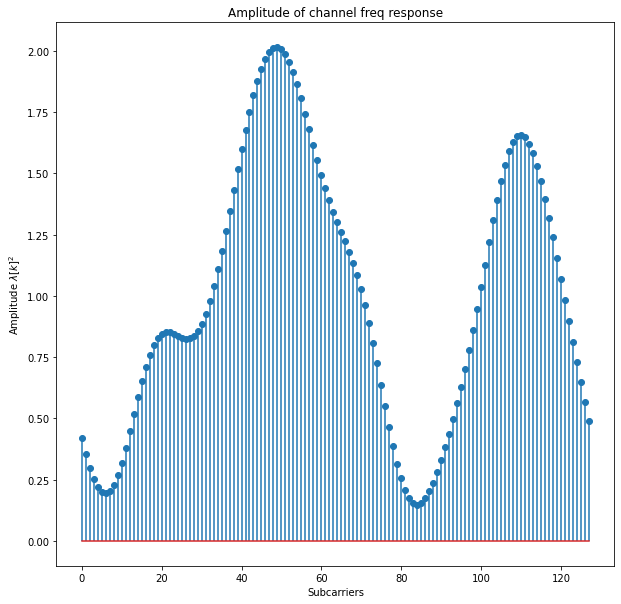

In [3]:
print(CIR.shape)
freqres = np.fft.fft(CIR,n=128, axis=0)
print(freqres.shape)
plt.figure(figsize = (10,10))
plt.stem(np.abs(freqres[:,:])**2)
plt.title("Amplitude of channel freq response")
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude $\lambda [k]^2$")
plt.show()

Establish the general procedure for maximizing the available bit rate
by optimizing the allocated powers p k and the number of bits b k for a given channel impulse response (and hence frequency response) and
based on the constraints described above. In order to simplify the
procedure, it is assumed that b k is real and is not restricted to an
integer.

Implement this optimization procedure for the particular realization
of the channel impulse response provided to you for 3 different values
E s /N 0 = 0, 10 and 20 dB, and evaluate the gain (in terms of bit rate)
with respect to uniform power allocation and/or uniform bit allocation.



In [4]:
pe = ser
SNRGap = (2/3)*(erfcinv(pe/2))**2
SNRGapdb = 10*np.log10(SNRGap)
print("SNR gap is {:.2f}, which gives {:.2f} dB".format(SNRGap, SNRGapdb))

SNR gap is 6.95, which gives 8.42 dB


<StemContainer object of 3 artists>

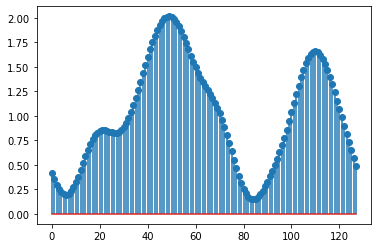

In [5]:
lambdai = np.zeros(freqres.shape)
lambdai[:,0] = np.abs(freqres[:,0])**2
plt.stem(lambdai)

Decision variable: 

$P_k$ = 0 si $\Gamma \sigma_{n,k}^2 > thresh$

avec
$\sigma_{n,k} = \frac{2N_0}{\lambda_i}$

Gain // uniform is: 1.0019109877659256
EBNO = 20.00 dB - Pmax = 256.00, 2N0 = 0.02, Level = 2.26, channels used = 128.00, Bitrate = 227.34


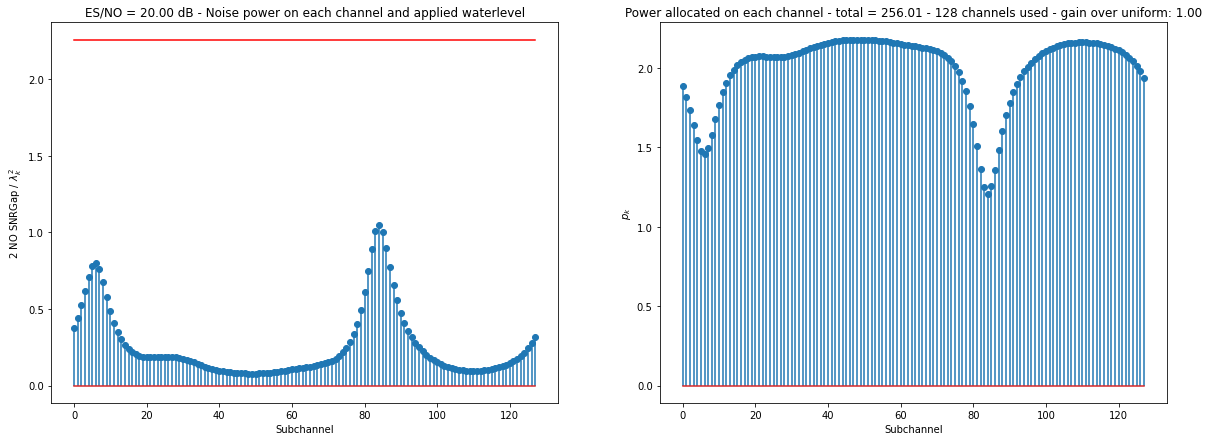

In [14]:
#SIMULATION TO RUN SEVERAL TIMES FOR DIFFERENT VALUES OF ESNOdb

Pmax = 256 #On se fixe le pmax
esnodb = 20
ESNO = 10**(esnodb/10)

sigs = 2
var = Pmax / (ESNO * (128**2/144)) #Ici j'ai 2N0 = VAR

N0 = var/2

level = 0
totalpower = 0

Pi = np.zeros(lambdai.shape)
while(totalpower<Pmax):
    level+=0.0001
    Pi[:] = level - 2*N0*SNRGap/(lambdai[:])
    Pi[Pi<0]=0
    totalpower = np.sum(Pi)
    
channelsused = Pi>0
channelsused = np.sum(channelsused)

#Compute bitrate
pk = Pi

SNR = pk*lambdai/(2*N0)

Bk = (1/2)*np.log2(1+SNR/SNRGap)
bitrate = np.sum(Bk)

#UNIFORM CASE
#############UNIFORM 
pk = 2
#Pk is the power on each subcarrier

SNRunif = pk*lambdai/(2*N0)

Bunif = (1/2)*np.log2(1+SNRunif/SNRGap)
bitrateunif = np.sum(Bunif)

print("Gain // uniform is: {}".format(bitrate/bitrateunif))



print("EBNO = {:.2f} dB - Pmax = {:.2f}, 2N0 = {:.2f}, Level = {:.2f}, channels used = {:.2f}, Bitrate = {:.2f}".format(esnodb, Pmax, 2*N0, level, channelsused, bitrate))
plt.figure(figsize = (20,7))
plt.subplot(121)

plt.stem(2*N0*SNRGap/(lambdai[:]))
plt.plot(np.ones(lambdai.shape)*level, 'r')
plt.title("ES/NO = {:.2f} dB - Noise power on each channel and applied waterlevel".format(esnodb))
plt.xlabel("Subchannel")
plt.ylabel("2 NO SNRGap / $\lambda_k ^2 $")
plt.subplot(122)
plt.xlabel("Subchannel")
plt.ylabel("$p_k$")
plt.title("Power allocated on each channel - total = {:.2f} - {:.0f} channels used - gain over uniform: {:.2f}".format(totalpower, channelsused, bitrate/bitrateunif))
plt.stem(Pi)
plt.savefig("Images_Resalloc/Bitrate{:.0f}dB.png".format(esnodb))
plt.show()








Total bitrate = 227.34 bits per symbol
Total bitrate = 226.91 bits per symbol


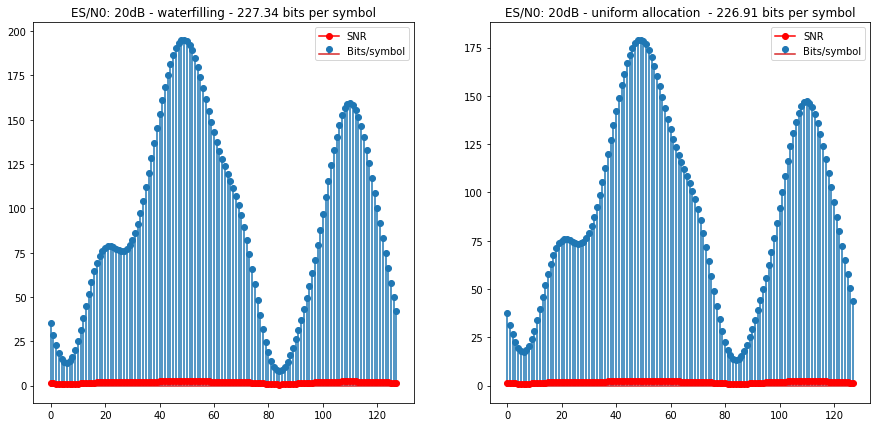

In [15]:
pk = Pi
#Pk is the power on each subcarrier

SNR = pk*lambdai/(2*N0)

Bk = (1/2)*np.log2(1+SNR/SNRGap)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.stem(SNR)
plt.title("ES/N0: {:.0f}dB - waterfilling - {:.2f} bits per symbol".format(esnodb, np.sum(Bk)))

plt.plot(Bk , '-ro')
plt.legend(["SNR", "Bits/symbol"])
print("Total bitrate = {:.2f} bits per symbol".format(np.sum(Bk)))


SNR = 2*lambdai/(2*N0)

Bk = (1/2)*np.log2(1+SNR/SNRGap)


plt.subplot(122)
plt.stem(SNR)
plt.title("ES/N0: {:.0f}dB - uniform allocation  - {:.2f} bits per symbol".format(esnodb, np.sum(Bk)))

plt.plot(Bk , '-ro')
plt.legend(["SNR", "Bits/symbol"])
print("Total bitrate = {:.2f} bits per symbol".format(np.sum(Bk)))
plt.savefig("Images_Resalloc/uniformvswater{:.0f}db.png".format(esnodb))
plt.show()

# Minimising MSE instead of maximising bitrate

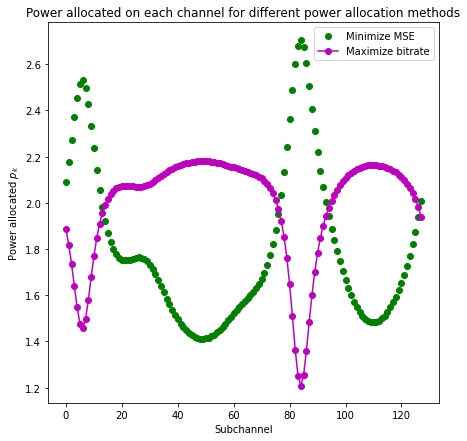

In [16]:
lambdak = np.fft.fft(CIR,n=128, axis=0)
Pmax = 256
Pchann = Pmax/((np.sqrt(np.abs(lambdak)))*np.sum(1/np.abs(lambdak)))

plt.figure(figsize = (7,7))
plt.plot(Pchann, 'go')
plt.plot(Pi,  '-mo')
plt.title("Power allocated on each channel for different power allocation methods")
plt.legend(["Minimize MSE","Maximize bitrate"])
plt.xlabel("Subchannel")
plt.ylabel("Power allocated $p_k$")
plt.savefig("Images_Resalloc/MinMSE.png")
plt.show()

# Old implementations

In [45]:
esnodb = 20
esno = 10**(-esnodb/10)
sigsq = 1/(128*esno)
power = sigsq * SNRGap



@interact
def splot(level=(0, 3, 0.001)):
    
    pk = sigsq/freqres


    plt.stem(np.abs(pk))
    plt.stem(np.ones(128)*level)
    
    pk[np.abs(pk)<level] = 0
    power = np.sum(np.abs(pk))
    plt.title("Power above threshold: {:.2f}".format(power))
    return power






interactive(children=(FloatSlider(value=1.0, description='level', max=3.0, step=0.001), Output()), _dom_classe…

In [46]:
def evaluate(level, sigmasquare):
    
    pk = sigmasquare/freqres    
    pk[np.abs(pk)<level] = 0
    power = np.sum(np.abs(pk))
    return power


def find_min_level(low,high,step, esnodb, powermax):
    
    sigsq = 1/(128*10**(-esnodb/10))
    
    
    tests = np.arange(low,high,step)
    minlev = 1000
    for i in tests:
        power = evaluate(i,sigsq)
        if(power<powermax and i<minlev):
            minlev = i
    if(minlev == 1000): print("Evaluate: Out of bound")
    return minlev

find_min_level(0.0,5,0.001, 20,1)




2.024

128
128
108


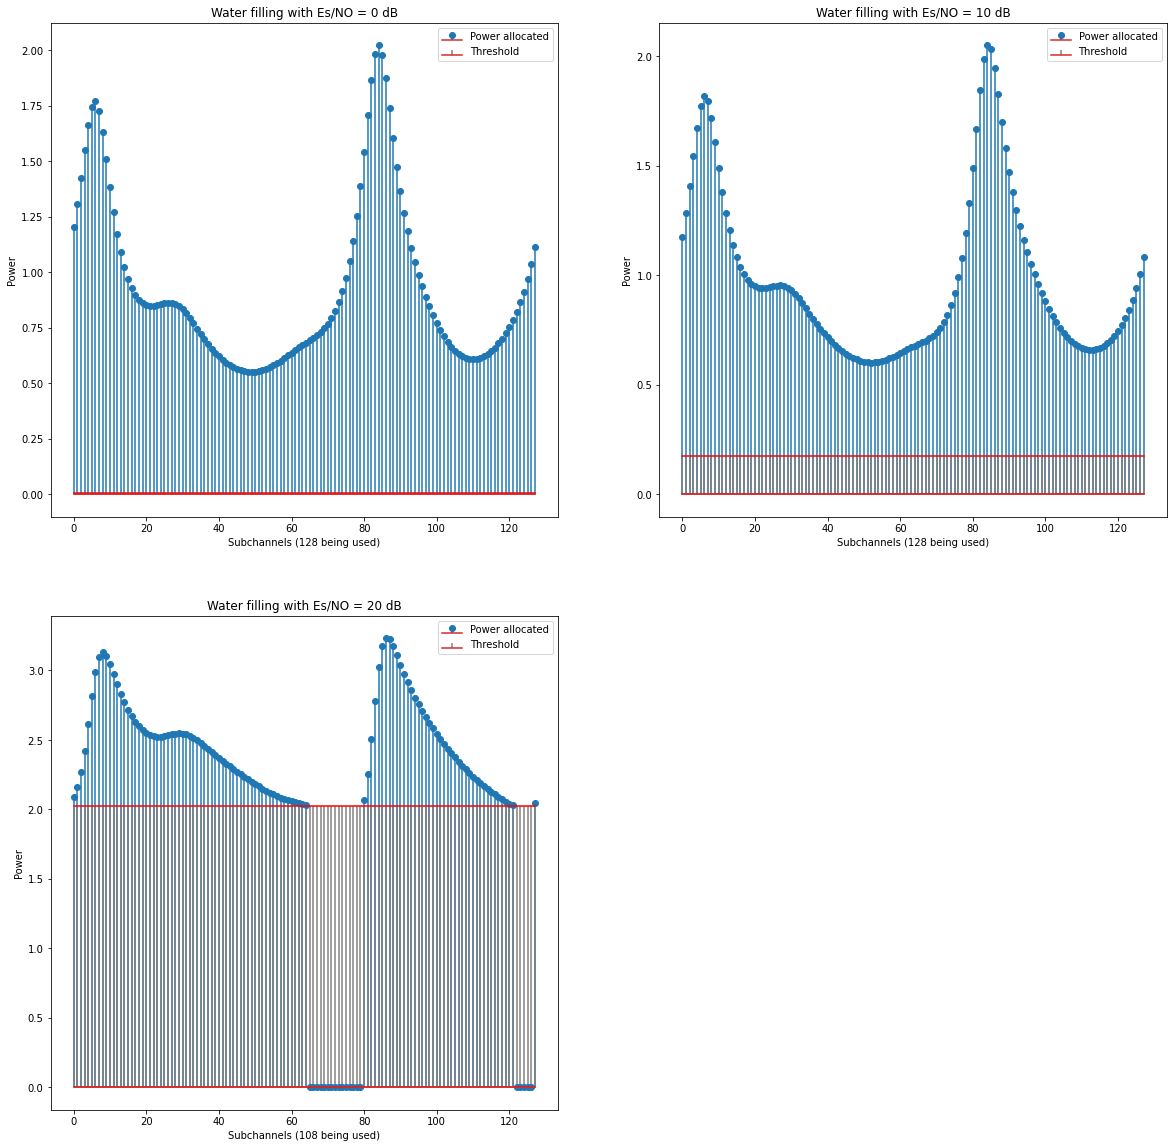

In [47]:
listdb = [0,10,20]

plt.figure(figsize = (20,20))
for i,j in enumerate(listdb):
    
    level = find_min_level(0.0,5,0.001, j,1)

    #vector = (1/2)* np.log2(1+   (freqres*power)/(sigsq*power)   )
    
    poweralloc = level - sigsq/freqres
    
    occur  = np.abs(poweralloc)>level #Create mask
    occur = np.sum(occur)
    print(occur)
    
    poweralloc[np.abs(poweralloc)<level]=0
    
    
    
    plt.subplot(221+i)    
    plt.stem(np.abs(poweralloc))
    
    
    
    plt.stem(np.ones(128)*level,linefmt='grey', markerfmt='r')
    
    
    
    plt.title("Water filling with Es/NO = {:.0f} dB".format(j))
    plt.xlabel("Subchannels ({:d} being used)".format(occur))
    #plt.yscale('log')
    plt.legend(['Power allocated', 'Threshold'])
    plt.ylabel("Power")
    
#Lets now do uniform allocation
#Each channel gets same power: p = sigsq *snrgap



## Water filling algo
$P_k = 0 $ si $\Gamma^2>\frac{1}{2\lambda ln(2)}$


$P_k = \frac{1}{2\lambda ln(2)} - \Gamma^2 $ sinon

avec $\Gamma$

128
36
0


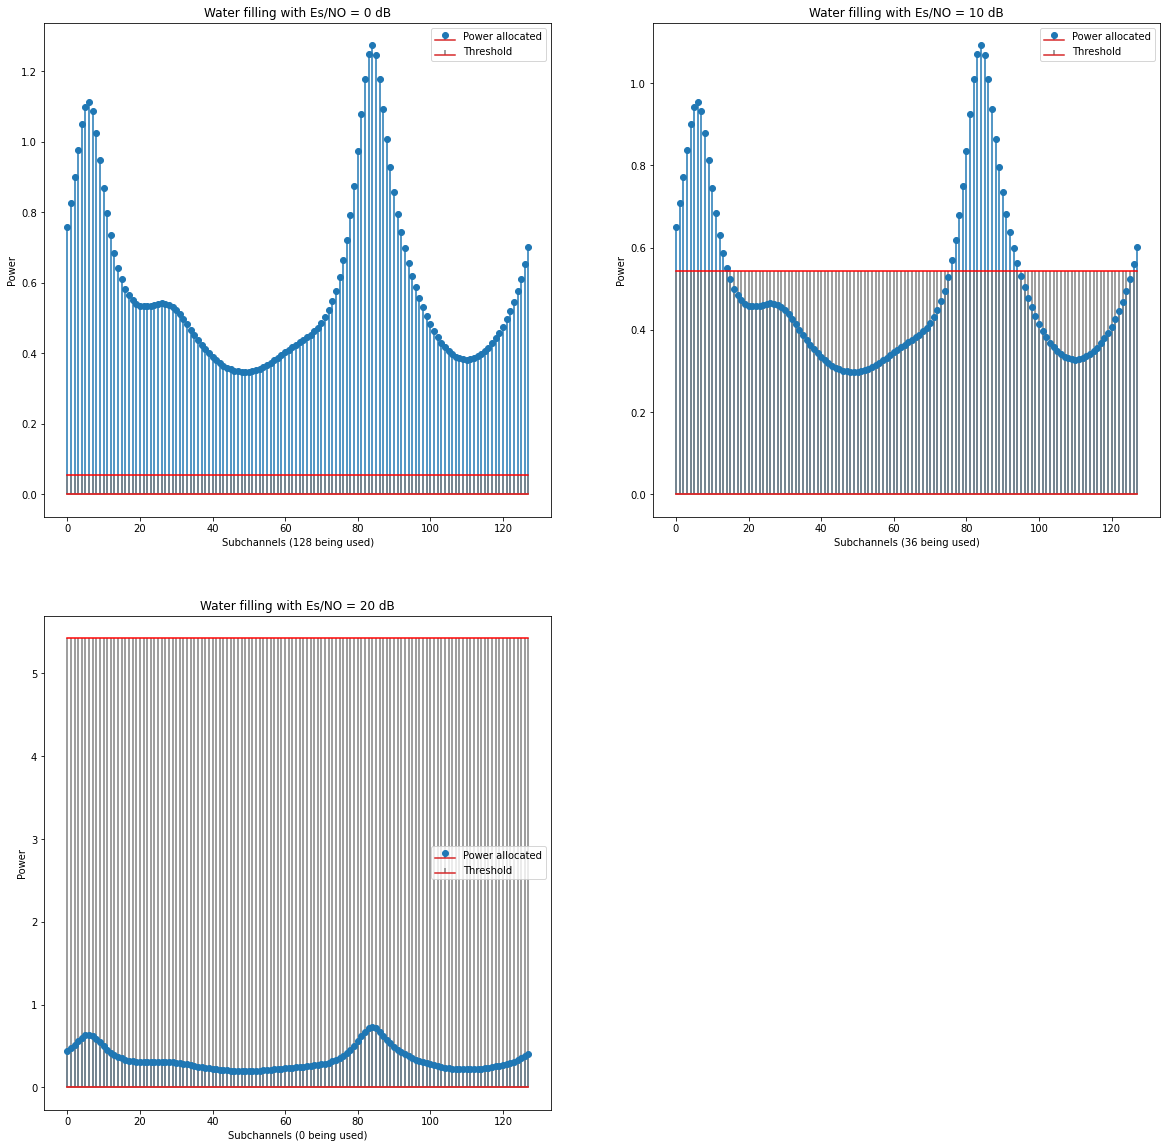

In [48]:
listdb = [0,10,20]

plt.figure(figsize = (20,20))
for i,j in enumerate(listdb):
    esnodb = j
    esno = 10**(-esnodb/10)
    sigsq = 1/(128*esno)
    
    power = sigsq * SNRGap

    #vector = (1/2)* np.log2(1+   (freqres*power)/(sigsq*power)   )
    
    poweralloc = (1/(2*(freqres)*np.log2(2))) - sigsq/freqres
    
    occur  = np.abs(poweralloc)>power #Create mask
    occur = np.sum(occur)
    print(occur)
    
    
    plt.subplot(221+i)    
    plt.stem(np.abs(poweralloc))
    
    
    
    plt.stem(np.ones(128)*power,linefmt='grey', markerfmt='r')
    
    
    
    plt.title("Water filling with Es/NO = {:.0f} dB".format(j))
    plt.xlabel("Subchannels ({:d} being used)".format(occur))
    #plt.yscale('log')
    plt.legend(['Power allocated', 'Threshold'])
    plt.ylabel("Power")
    
#Lets now do uniform allocation
#Each channel gets same power: p = sigsq *snrgap



 ## Computing data throughput
  - Plot BER/SNR for each type of constellation
  - View SNR on each channel and choose right constellation
  - Sum all bits (constellations) on all channels
  
 PAS du tout, juste prendre les formules de louis et mettre les bon pk

In [49]:
esnodb = 0 #En decibel
esno = 10**(-esnodb/10) #Je convertis en linéaire
N0 = (1/2)* (128/144) * (2/esno)